In [ ]:
!rm -rf ./ML4CV_Assignment
!git clone https://github.com/liuktc/ML4CV_Assignment.git
!pip install tensorboard
!pip install pyngrok
!git clone https://github.com/facebookresearch/dinov3.git

import sys
sys.path.append('/kaggle/working/ML4CV_Assignment')

In [ ]:
import os
import tensorboard
from tensorboard import program

LOG_DIR = "./runs"  # your log folder

tb = program.TensorBoard()
tb.configure(argv=[None, "--logdir", LOG_DIR, "--host", "0.0.0.0", "--port", "6006"])
url = tb.launch()
print("TensorBoard running at:", url)

In [ ]:
!ngrok authtoken YOUR_NGROK_AUTH_TOKEN

In [ ]:
from pyngrok import ngrok

public_url = ngrok.connect(6006)
print("Access TensorBoard here:", public_url)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import json

import torch
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

from plot import color, semantic_embeddings_plot
from dataset import StreetHazardDataset, PadToMultipleOf16, StreetHazardDatasetTriplet
from _model import DINOv2_SemanticSegmentation
from loss import nt_xent_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

COLAB = False
KAGGLE = False
NUM_CLASSES = 13
SEED = 42

# Seed everything
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/home/federico/repos/ML4CV_Assignment/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
if COLAB:
    !wget https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar -O train.tar
    !tar -xf train.tar

## Data Preparation


In [ ]:
PadToMultipleOf16().convert_dims((480,480))

In [3]:
ORIGINAL_IMAGE_SIZE = (720, 1280)
IMAGE_SIZE = PadToMultipleOf16().convert_dims((720//2, 1280//2))  
# assert IMAGE_SIZE[0] %4 == 0 and IMAGE_SIZE[1] % 4 == 0
BATCH_SIZE = 1
POSITIVE_PAIRS = True
PIXEL_PER_CLASS = 3

# Percorsi dei file
if COLAB:
    annotations_train_file = "/content/train/train.odgt"
    annotation_val_file = "/content/train/validation.odgt"
    img_dir = "/content/train"
elif KAGGLE:
    annotations_train_file = "../input/streethazards-train/train/train.odgt"
    annotation_val_file = "../input/streethazards-train/train/validation.odgt"
    img_dir = "../input/streethazards-train/train"
else:
    annotations_train_file = "/home/federico/.cache/kagglehub/datasets/lucadome/streethazards-train/versions/1/train/train.odgt"
    annotation_val_file = "/home/federico/.cache/kagglehub/datasets/lucadome/streethazards-train/versions/1/train/validation.odgt"
    annotation_test_file = "/home/federico/Downloads/streethazards_test/test/test.odgt"
    img_dir = "/home/federico/.cache/kagglehub/datasets/lucadome/streethazards-train/versions/1/train/"
    img_dir_test = "/home/federico/Downloads/streethazards_test/test/"


image_transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE, interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE, interpolation=InterpolationMode.NEAREST),
    ]
)


# Crea il dataset
dataset_train = StreetHazardDataset(
    annotations_train_file,
    img_dir,
    image_transform=image_transform,
    target_transform=target_transform,
    positive_pairs=True,
    pixel_per_class=PIXEL_PER_CLASS
)

dataset_val = StreetHazardDataset(
    annotation_val_file,
    img_dir,
    image_transform=image_transform,
    target_transform=target_transform,
    positive_pairs=True,
    pixel_per_class=PIXEL_PER_CLASS
)

dataset_test = StreetHazardDataset(
    annotation_test_file,
    img_dir_test,
    image_transform=image_transform,
    target_transform=target_transform,
    positive_pairs=True,
    pixel_per_class=PIXEL_PER_CLASS
)

dl_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
dl_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
# Sample a small random subset of training data for metrics
dl_train_small = DataLoader(Subset(dataset_train, list(torch.randperm(len(dataset_train))[:3])), batch_size=1, shuffle=True)

In [57]:
from dataset import compute_class_frequency

if os.path.exists("class_frequencies.pt"):
    freq = torch.load("class_frequencies.pt")
else:
    freq = compute_class_frequency(dl_train, num_samples_per_class=50, num_images=1000)
    torch.save(freq, "class_frequencies.pt")

class_weights = 1.0 / (freq / freq.max())

In [58]:
class_weights

tensor([ 1.0000,  1.2589,  1.8875,  2.1030, 19.7580,  1.3466,  1.1073,  1.0010,
         1.2787,  1.1447,  4.3177,  1.5397,  3.2022])

Image shape: torch.Size([3, 368, 640])
Segmentation shape: torch.Size([368, 640])


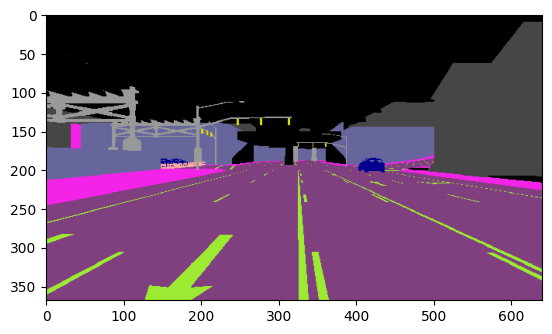

In [59]:
# Show a sample
for image, segmentation, _ in dl_train:
        
    print(f"Image shape: {image[0].shape}")
    print(f"Segmentation shape: {segmentation[0].shape}")
    # print(f"Anchor pixel: {anchor_idx}")
    # print(f"Positive pixel: {positive_idx[0]}")
    # print(f"Negative pixel: {negative_idx[0]}")
    plt.imshow(color(segmentation[0].cpu().numpy()))
    plt.show()
    break

# Semantic Segmentation

In [ ]:
from train import train_semantic_segmentation

# backbone = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14", pretrained=True)
REPO_DIR = "./dinov3"
# DINOv3 ViT models pretrained on web images
backbone = torch.hub.load(REPO_DIR, 'dinov3_vits16', source='local', weights="https://dinov3.llamameta.net/dinov3_vits16/dinov3_vits16_pretrain_lvd1689m-08c60483.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiNGZqbnc4dXdxb21zNHh3dm0xbTZ4anF2IiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTU3MDU1NTl9fX1dfQ__&Signature=LJ5NrLId6%7Ey6opPJXXPh6q8rEj%7EFRUlD3WkMR3tlZ9ELqeQJDs46f16bzRFPbkHDttYNJqpemZqSNkiPhWrr6KtCA3KNPRjYxerHDlhO7f72Eq6U8owR6RisyP1evJVzyAI3qnbYdb7yIQcNBRkElkhpYwEJRNQLvTo1RR1kqc5G6Hdbe2ngBvEzCmcBKaijImxqaz-J7pPSgLOUtU3%7ERqlglfptkOy3KNmlu0Ib3fd2olH2fYFimC7bN1hBLJn7AH-JmEyLc1zLILNNOL03zj%7E7X8nCRxLZa3kLqN%7E4CrPdKQbNhGXEkZ9N3pq71Fk9pwRDZGLQgCYB8PeASh4r4Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1107184587434197")

criterion = nn.CrossEntropyLoss()
EPOCHS = 10
LOAD_WEIGHTS = False
LEARNING_RATE = 1e-3
EMBEDDING_SIZE = 256

# segmentation_model = DINOv2_SemanticSegmentation(
#     num_classes=NUM_CLASSES, image_size=IMAGE_SIZE, embedding_size=EMBEDDING_SIZE
# ).to(device)
from model_new import DinoSegmentation
segmentation_model = DinoSegmentation(
    dino_model=backbone,
    num_classes=NUM_CLASSES,
    dino_out_dim=384,
    cnn_out_dim=128,
    embed_dim=128
).to(device)

# for param in segmentation_model.feature_extractor.parameters():
#     param.requires_grad = False

In [ ]:
if LOAD_WEIGHTS:
    if COLAB:
        path_prefix = "/content/"
    elif KAGGLE:
        path_prefix = "/kaggle/input/"
    else:
        path_prefix = "./"
    path = os.path.join(path_prefix, "segmentation_model.pth")
    segmentation_model.load_state_dict(torch.load(path, map_location=device))

In [ ]:
segmentation_optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, segmentation_model.parameters()), lr=LEARNING_RATE
)

train_semantic_segmentation(
    model=segmentation_model,
    criterion=criterion,
    dl_train=dl_train,
    dl_val=dl_val,
    device=device,
    epochs=EPOCHS,
    optimizer=segmentation_optimizer,
    original_image_size=ORIGINAL_IMAGE_SIZE
)

In [ ]:
# Save the segmentation model
torch.save(segmentation_model.state_dict(), "segmentation_model.pth")

## Metric Learning


In [4]:
from model_new import DinoMetricLearning, DinoUpsampling
from loss import triplet_loss
from train import train_metric_learning

EPOCHS = 40
TEMPERATURE = 0.05
LEARNING_RATE = 1e-4
LOAD_WEIGHTS = False
EMBEDDING_SIZE = 512

backbone = torch.hub.load('./dinov3', 'dinov3_vits16', source='local', weights="https://dinov3.llamameta.net/dinov3_vits16/dinov3_vits16_pretrain_lvd1689m-08c60483.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiMTc0aW56OWd1aW9nZXNoN25pZ2dwNmdsIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTU5Njk3NjR9fX1dfQ__&Signature=LTfoFPHH4SWFA7caaZ9aNOiHg5FgGac-fxuQ42Et%7EJdiySSWbkBMdobVjX0PhNlqGiD3VPweg0kl7YO0-ZTywb1VKWfdnRzS-iojQgXjBBegESSNQPaVjVARJo%7E6yDzKU%7Ev-HE-E0P6TkWKx6hvanKT8QpHkzlSqWGBVqu-T13cq%7EWms56RspK%7EsqsEiO9g6j5dUREEERWIQ86OQyLEWWF6WuC%7ECOcuyYyyCXtMnKZQb%7ERptBMEpdtYz8anInDX2mTx37Y97EcYVDay-FiPasUX3T4QKJJ2hCio3e6%7EX6n6Hpl%7EDz0a6dYyOyQ-aF1kOpA7C1MD4xXNYNVl82Qig7A__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1831377760851783")
backbone = backbone.to(device)
metric_learning_model = DinoMetricLearning(
    backbone, dino_out_dim=384, cnn_out_dim=128, embed_dim=EMBEDDING_SIZE
).to(device)

metric_learning_model.load_state_dict(torch.load("metric_learning_epoch_5.pth"))

# metric_learning_model = DinoUpsampling(backbone, out_dim=EMBEDDING_SIZE)
# metric_learning_model = metric_learning_model.to(device)
# metric_learning_model.load_state_dict(torch.load("metric_learning_model.pth", map_location=device))

# metric_learning_model = DINOv2_SemanticSegmentation(
#     num_classes=None, image_size=IMAGE_SIZE, embedding_size=EMBEDDING_SIZE
# ).to(device)

if LOAD_WEIGHTS:
    if COLAB:
        path_prefix = "/content/drive/"
    elif KAGGLE:
        path_prefix = "/kaggle/working/"
    else:
        path_prefix = "./"
    path = os.path.join(path_prefix, "metric_learning_model2.pth")

    metric_learning_model.load_state_dict(torch.load(path, map_location=device))

# for param in metric_learning_model.feature_extractor.parameters():
#     param.requires_grad = False

from loss import MagnetLoss, NT_Xent_Loss, Proxy_Anchor

# criterion = MagnetLoss(num_classes=NUM_CLASSES, num_clusters=1, margin=0.1)
# criterion = NT_Xent_Loss(temperature=TEMPERATURE)
# class_weights_no_zero = class_weights.clone()
# class_weights_no_zero[0] = 0
# criterion = Proxy_Anchor(num_classes=NUM_CLASSES,
#                          embedding_size=EMBEDDING_SIZE,
#                          class_weights=class_weights_no_zero,
#                          device=device,
#                          use_aux_ce=True,
#                          num_pixels_per_class=400)

# torch.nn.utils.clip_grad_norm_(metric_learning_model.parameters(), 5.0)
from pytorch_metric_learning import distances, losses, miners, reducers, testers 

# distance = distances.CosineSimilarity() 
# reducer = reducers.ThresholdReducer(low=0) 
# loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer) 
# mining_func = miners.TripletMarginMiner( margin=0.2, distance=distance, type_of_triplets="semihard" )
distance = distances.LpDistance(power=2)  # Euclidean distance works better with ProxyAnchor
# Alternative: distances.CosineSimilarity() if your embeddings are normalized

loss_func = losses.ProxyAnchorLoss(
    num_classes=NUM_CLASSES,
    embedding_size=EMBEDDING_SIZE,
    margin=0.2,       # Typical value for ProxyAnchor (higher than triplet margin)
    alpha=30,         # Scaling parameter (controls pull/push strength)
    distance=distance
).to(device)

# model_params = [i for i in metric_learning_model.parameters() if i.requires_grad] + [i for i in loss_func.parameters() if i.requires_grad]
model_params = [i for i in loss_func.parameters() if i.requires_grad]


optimizer = torch.optim.Adam(
    model_params,
    lr=LEARNING_RATE,
)

train_metric_learning(
    model=metric_learning_model,
    criterion=loss_func,
    dl_train=dl_train,
    dl_train_small=dl_train_small,
    test_dataset=dataset_test,  # Pass the test dataset for computing test metrics
    dl_val=dl_val,
    # mining_func=mining_func,
    device=device,
    epochs=EPOCHS,
    optimizer=optimizer,
    print_loss=False,
    plot_interval=500,
    metric_interval=50000
)

  0%|          | 0/5125 [00:00<?, ?it/s]

Epoch 0/40 - 35.485939025878906


 10%|▉         | 500/5125 [09:26<1:27:53,  1.14s/it]

Epoch 0/40 - 31.12542724609375


 20%|█▉        | 1000/5125 [18:53<1:17:12,  1.12s/it]

Epoch 0/40 - 24.664886474609375


 29%|██▉       | 1500/5125 [28:20<1:08:26,  1.13s/it]

Epoch 0/40 - 18.59180450439453


 39%|███▉      | 2000/5125 [37:46<58:41,  1.13s/it]  

Epoch 0/40 - 17.017654418945312


 49%|████▉     | 2500/5125 [47:13<49:32,  1.13s/it]  

Epoch 0/40 - 12.692216873168945


 59%|█████▊    | 3000/5125 [57:06<39:51,  1.13s/it]  

Epoch 0/40 - 9.919992446899414


 68%|██████▊   | 3500/5125 [1:06:25<30:14,  1.12s/it]

Epoch 0/40 - 6.916247367858887


 78%|███████▊  | 4000/5125 [1:15:39<20:41,  1.10s/it]

Epoch 0/40 - 3.142444372177124


 88%|████████▊ | 4500/5125 [1:24:50<11:36,  1.11s/it]

Epoch 0/40 - 4.414246559143066


 98%|█████████▊| 5000/5125 [1:33:58<02:14,  1.07s/it]

Epoch 0/40 - 3.428201675415039


  0%|          | 0/5125 [00:00<?, ?it/s]

Epoch 1/40 - 0.9881401062011719


 10%|▉         | 500/5125 [09:15<1:22:52,  1.08s/it]

Epoch 1/40 - 2.4585819244384766


 20%|█▉        | 1000/5125 [18:24<1:15:58,  1.11s/it]

Epoch 1/40 - 0.6625827550888062


 29%|██▉       | 1500/5125 [27:41<1:05:42,  1.09s/it]

Epoch 1/40 - 0.908913791179657


 39%|███▉      | 2000/5125 [36:57<57:55,  1.11s/it]  

Epoch 1/40 - 0.37862664461135864


 49%|████▉     | 2500/5125 [46:19<49:18,  1.13s/it]  

Epoch 1/40 - 0.45461079478263855


 59%|█████▊    | 3000/5125 [55:45<39:37,  1.12s/it]  

Epoch 1/40 - 0.27839553356170654


 68%|██████▊   | 3500/5125 [1:05:10<30:34,  1.13s/it]

Epoch 1/40 - 0.41445812582969666


 78%|███████▊  | 4000/5125 [1:14:33<21:08,  1.13s/it]

Epoch 1/40 - 0.21552179753780365


 88%|████████▊ | 4500/5125 [1:23:57<11:43,  1.13s/it]

Epoch 1/40 - 0.29061415791511536


 88%|████████▊ | 4504/5125 [1:24:05<11:35,  1.12s/it]


KeyboardInterrupt: 

In [ ]:
torch.save(metric_learning_model.state_dict(), "metric_learning_model.pth")

In [5]:
torch.save(loss_func.proxies, "proxies.pth")

In [10]:
from metrics import outlier_detection_roc_auc
from model_new import OutlierDetector, ProxyOutlierDetector

# detector = OutlierDetector(
#     metric_learning_model,
#     num_classes=NUM_CLASSES,
#     train_dataloader=dl_train_small,
#     device=device,
#     num_samples_per_class=512,
#     pca_dim=128,
# )

detector = ProxyOutlierDetector(
    metric_learning_model,
    proxies=loss_func.proxies,
    device=device,
    normalize=True)

# detector.load_state_dict(torch.load("outlier_detector.pth", map_location=device))

Computing test metrics:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([368, 640]) torch.Size([368, 640])


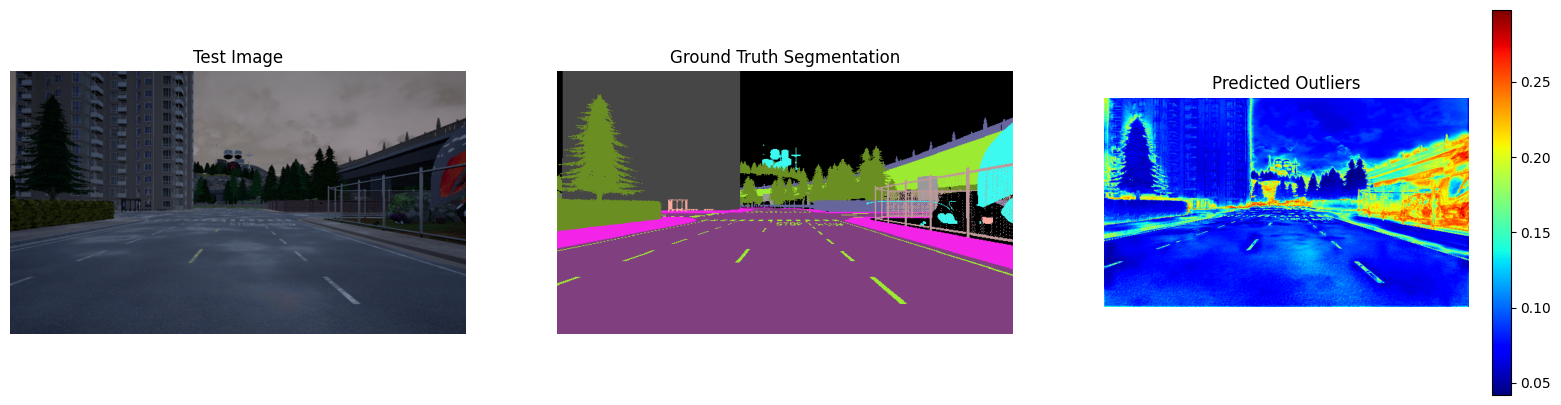

Computing test metrics:  20%|██        | 1/5 [00:00<00:03,  1.14it/s]

0.9243251527153025
torch.Size([368, 640]) torch.Size([368, 640])


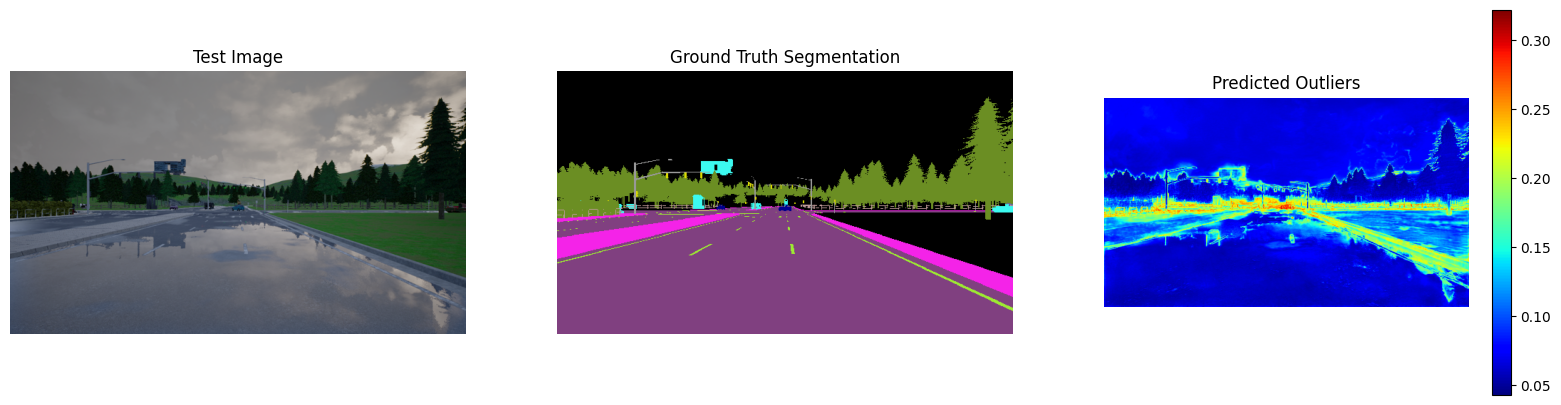

Computing test metrics:  40%|████      | 2/5 [00:01<00:02,  1.09it/s]

0.9120958645834495
torch.Size([368, 640]) torch.Size([368, 640])


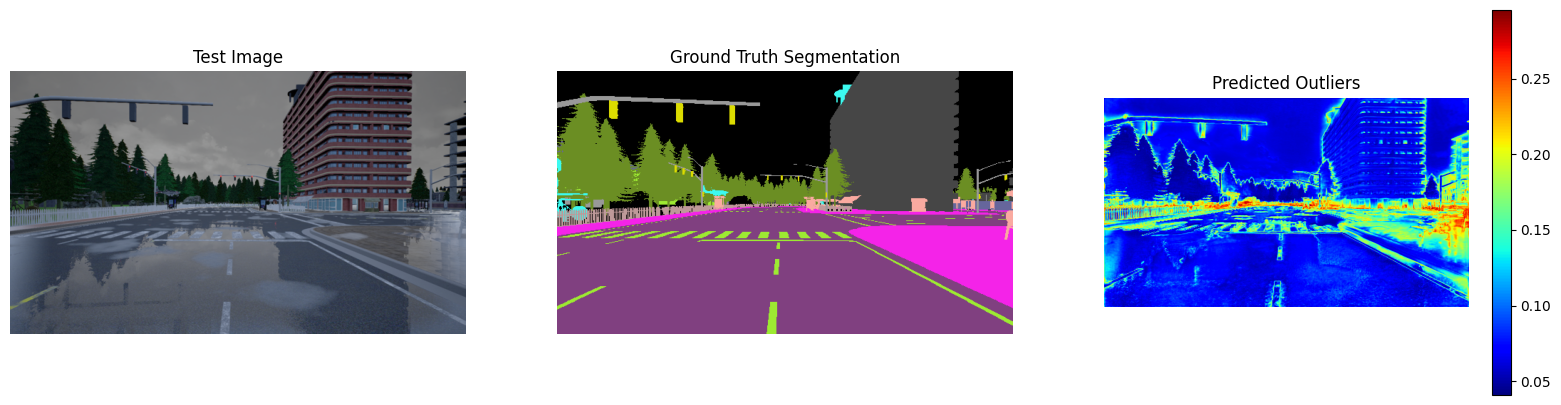

Computing test metrics:  60%|██████    | 3/5 [00:02<00:01,  1.20it/s]

0.9124596376934192
torch.Size([368, 640]) torch.Size([368, 640])


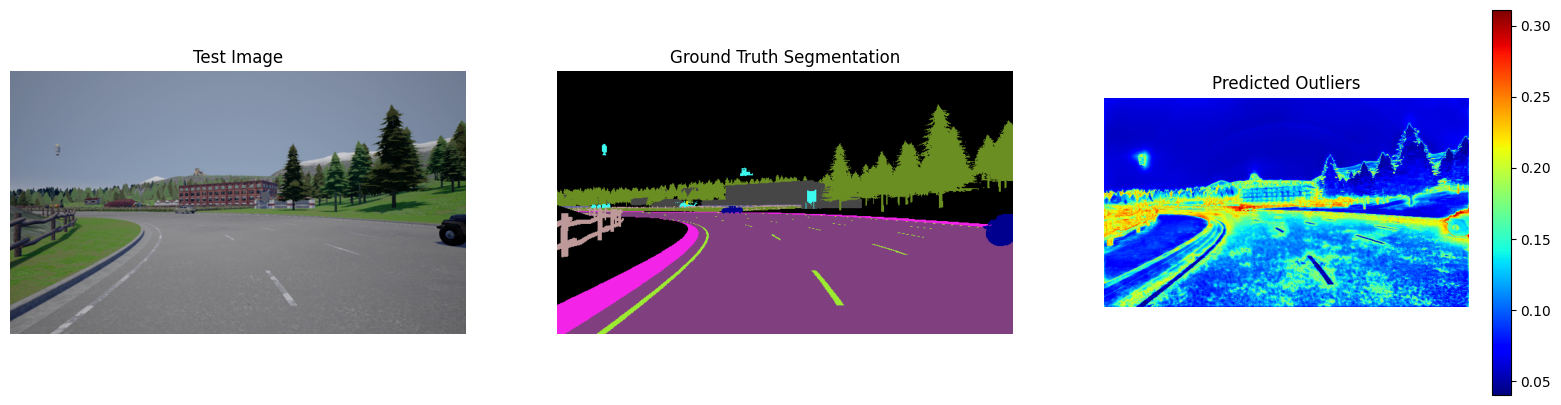

Computing test metrics:  80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

0.8891090940520844
torch.Size([368, 640]) torch.Size([368, 640])


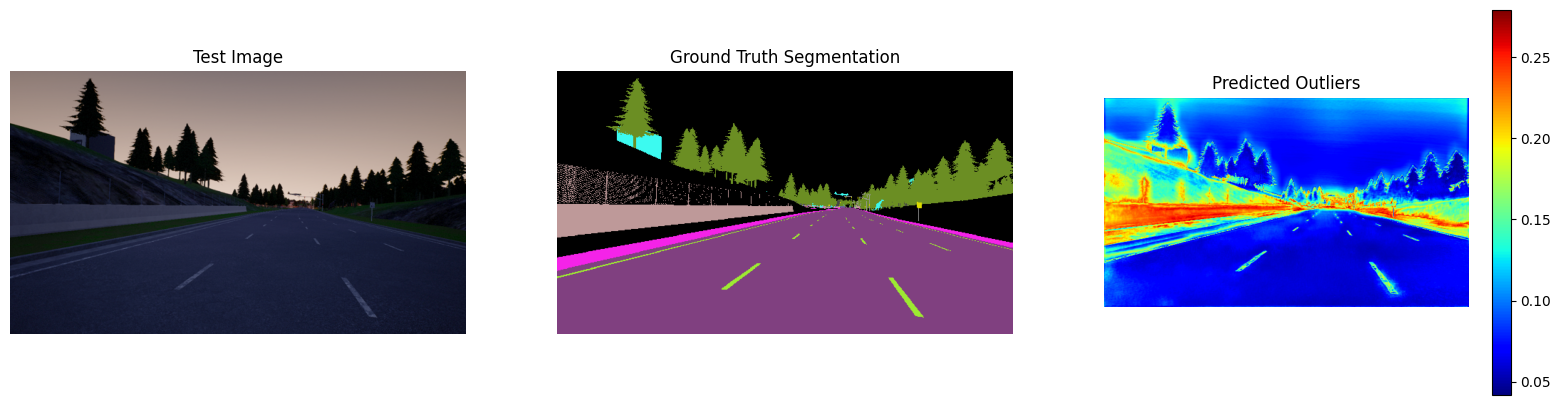

Computing test metrics: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

0.7678928873692275
[0.9243251527153025, 0.9120958645834495, 0.9124596376934192, 0.8891090940520844, 0.7678928873692275]


In [12]:
# Compute the metric over 5 random test images
scores = []
test_indices = torch.randperm(len(dataset_test))[:5]
for idx in tqdm(test_indices, desc="Computing test metrics"):
    test_image, test_segmentation, _ = dataset_test[idx]
    outliers_map = detector(test_image.unsqueeze(0).to(device))[0].detach().cpu()
    outliers_gt = (test_segmentation == 13).int().detach().cpu()
    print(outliers_gt.shape, outliers_map.shape)
    score = outlier_detection_roc_auc(outliers_gt, outliers_map)
    scores.append(score)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(test_image.permute(1, 2, 0).cpu().numpy())
    plt.title("Test Image")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(color(test_segmentation.cpu().numpy()))
    plt.title("Ground Truth Segmentation")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(outliers_map.cpu().numpy(), cmap="jet")
    plt.title("Predicted Outliers")
    plt.axis("off")
    plt.colorbar()
    plt.show()
    print(score)
mean_score = sum(scores) / len(scores)
# print(f"Test Outlier ROC AUC: {mean_score}")
print(scores)

In [69]:
torch.save(detector.state_dict(), "outlier_detector.pth")
torch.save(metric_learning_model.state_dict(), "metric_learning_model_proxy.pth")

In [ ]:
semantic_embeddings_plot(metric_learning_model, dl_train, num_points=10000, device=device)

In [ ]:
torch.randperm(10)[:5].cpu().numpy()

In [ ]:
if COLAB:
    !wget https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar -O test.tar
    !tar -xf test.tar

In [ ]:
# Load test dataset
if COLAB:
    annotations_file = "/content/test/test.odgt"
    img_dir = "/content/test"
elif KAGGLE:
    annotations_file = "/kaggle/input/test/test.odgt"
    img_dir = "/kaggle/input/test"
else:
    annotations_file = "./data/test/test.odgt"
    img_dir = "./data/test"

test_dataset = StreetHazardDataset(
    annotations_file,
    img_dir,
    image_transform=image_transform,
    target_transform=target_transform,
    positive_pairs=True,
    pixel_per_class=40
)

dl_test = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [ ]:
for images, segmentations, (pos_pairs, pos_pairs_relative) in dl_test:
    print(images.size(), segmentations.size(), pos_pairs.size())
    
    segmentations = segmentations[0].cpu().numpy()
    pos_pairs = pos_pairs[0].cpu().numpy()
    
    plt.imshow(color(segmentations))
    break
    
    # print(segmentations.shape, pos_pairs.shape)
    
    # for i in pos_pairs:
    #     print(segmentations[i[0]], segmentations[i[1]])
    # break

In [ ]:
semantic_embeddings_plot(metric_learning_model, dl_test, num_points=100000)

In [ ]:
import torch, gc
import os

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Save the model
# torch.save(metric_learning_model.state_dict(), "model.pth")

# metric_learning_model = torch.load("./model2.pth", map_location=torch.device('cpu'))
# Load the state dict model
metric_learning_model = DINOv2_SemanticSegmentation(num_classes=None, image_size=IMAGE_SIZE, fine_grained_features_size=128)
metric_learning_model.load_state_dict(torch.load("model2.pth", map_location=torch.device('cpu')))

## Idea for outlier detection

- For each segmentation class, calculate its distribution (Gaussian assumption, so just calculate mean and variance).
- With this pre-calculated distributions, we can calculate, for each pixel, the probability of it belonging to a certain class. If the $\max$ of these probabilities is low, we can classify that pixel as outlier (rely on threshold).

In [ ]:
from tqdm.auto import tqdm
def calculate_distribution_for_each_class(metric_learning_model, dl, num:int = 100):
    res = {}
    count = 0
    for images, segmentations, _ in tqdm(dl, total=num // 4):
        count += len(images)
        images = images.to(device)
        segmentations = segmentations.to(device)
        unique_classes = torch.unique(segmentations)
        
        # Calculate the embedding for each pixel
        pixel_embeddings = metric_learning_model(images)
        
        B = len(images)
        for i in range(B):
            # For each class, calculate the mean of the embeddings
            for c in unique_classes:
                mask = segmentations[i] == c
                
                # print("mask", mask.shape)
                # print("pixel_embeddings", pixel_embeddings[i].shape)
                # print("images", images[i].shape)
                # print("segmentations", segmentations[i].shape)
                c = c.item()
                if mask.sum() > 1:
                    if c not in res:
                        # print("AAAAAA", pixel_embeddings[i][:, mask].shape)
                        res[c] = {"mean": pixel_embeddings[i][:, mask].mean(dim=(1)).cpu().detach().numpy(),
                                "std": pixel_embeddings[i][:, mask].std(dim=(1)).cpu().detach().numpy(),
                                "count": mask.sum().cpu().detach().numpy(),}
                        
                        # print("res[c]['mean']", res[c]["mean"].shape)
                        # print("res[c]['std']", res[c]["std"].shape)
                        # print("res[c]['count']", res[c]["count"])
                    else:
                        res[c]["mean"] = (res[c]["mean"] * res[c]["count"] + pixel_embeddings[i][:, mask].sum(dim=(1)).cpu().detach().numpy()) / (res[c]["count"] + mask.sum().cpu().detach().numpy())
                        res[c]["std"] = (res[c]["std"] * res[c]["count"] + pixel_embeddings[i][:, mask].std(dim=(1)).cpu().detach().numpy()) / (res[c]["count"] + mask.sum().cpu().detach().numpy())
                        # res[c][]
                        res[c]["count"] += mask.sum().cpu().detach().numpy()
        print(count)
        if count > num:
            break
    return res

def multivariate_pdf(x, means, cov_matrix):
    d = len(means)
    return np.exp(-0.5 * (x - means).T @ np.linalg.inv(cov_matrix) @ (x - means)) / np.sqrt(np.linalg.det(cov_matrix) * (2 * np.pi) ** d)

# class_std_inv_cache = {}
def probability_belong_to_class(pixel_embedding, class_mean, class_std):
    # if tuple(class_std) not in class_std_inv_cache:
    #     class_std_inv_cache[tuple(class_std)] = np.linalg.inv(np.diag(class_std))
    #     # class_std_inv_cache[tuple(class_std)] = np.diag(class_std)
        
        
    # class_std_inv = class_std_inv_cache[tuple(class_std)]
    # print("x-m",(pixel_embedding - class_mean))
    # print("class_std_inv", class_std_inv)
    # print("prod", (pixel_embedding - class_mean).T @ class_std_inv)
    # print("final prod", (pixel_embedding - class_mean).T @ class_std_inv @ (pixel_embedding - class_mean))
    # print((pixel_embedding - class_mean).T @ class_std_inv @ (pixel_embedding - class_mean))
    # return 1 / np.exp(np.linalg.norm((pixel_embedding - class_mean) * class_std))
    # print(pixel_embedding.shape)
    # print(class_mean.shape)
    return F.cosine_similarity(torch.tensor(pixel_embedding), torch.tensor(class_mean), dim=0)
    # return np.exp(-1 * np.linalg.norm((pixel_embedding - class_mean) / (class_std * 640)))
    # return multivariate_pdf(pixel_embedding, class_mean, class_std) / multivariate_pdf(class_mean, class_mean, class_std)

def classify_new_pixel(pixel_embedding, class_distributions):
    res = {}
    for c in class_distributions:
        m = class_distributions[c]["mean"]
        s = class_distributions[c]["std"]
        res[c] = probability_belong_to_class(pixel_embedding, m, s)
    return res   

In [ ]:
import numpy as np
distributions = calculate_distribution_for_each_class(metric_learning_model, dl_train, num=25)

In [ ]:
distributions[1]

In [ ]:
# For each class, print the probability distribution of the pixel belonging to that class (expected to be close to 1)
results = {}
for images, segmentations, _ in dl_train:
    images = images.to(device)
    segmentations = segmentations.to(device)
    pixel_embeddings = metric_learning_model(images)
    pixel_embeddings = pixel_embeddings.view(pixel_embeddings.size(0),pixel_embeddings.size(1), -1)
    segmentations = segmentations.view(segmentations.size(0), -1)
    
    B = len(images)
    for i in range(B):
        # print(pixel_embeddings[i].shape, pixel_embeddings[i].size(0))
        # pixel_embeddings[i] = pixel_embeddings[i].view(pixel_embeddings[i].size(0), -1)
        for c in tqdm(torch.unique(segmentations[i])):
            mask = segmentations[i] == c
            mask_len = mask.sum()
            masked_pixel_embeddings = pixel_embeddings[i][:, mask]
            # for j in tqdm(range(mask_len)):
            for j in tqdm(range(min(100, mask_len))):
                p = masked_pixel_embeddings[:, j].detach().cpu().numpy()
                # print(p.shape)
                # prob = classify_new_pixel(p, distributions)
                # print(p)
                # print(distributions[c.item()]["mean"])
                # if c.item() not in results:
                #     results[c.item()] = {}
                # print(np.linalg.norm((p - distributions[c.item()]["mean"]) / distributions[c.item()]["std"]) / 640)
                prob = probability_belong_to_class(p, distributions[c.item()]["mean"], distributions[c.item()]["std"])
                # Calculate the distance between the pixel embedding and the mean of each class (considering the variance)
                # for other_c in torch.unique(segmentations[i]):
                #     if other_c.item() not in results[c.item()]:
                #         results[c.item()][other_c.item()] = []
                #     other_c = other_c.item()
                #     prob = np.linalg.norm((p - distributions[other_c]["mean"]) / np.sqrt(distributions[other_c]["std"])) / 640
                #     results[c.item()][other_c].append(prob)
                # print(prob)
                # break
            # break
        
                if c.item() not in results:
                    results[c.item()] = []
                    
                results[c.item()].append(prob)            
                
            # for j in range(len(images[i, :, mask])):
            #     pixel_embedding = pixel_embeddings[i][:, j]
            #     print(pixel_embedding.shape)
            #     prob = probability_belong_to_class(pixel_embedding,
            #                                        distributions[c.item()]["mean"],
            #                                        np.diag(distributions[c.item()]["std"].detach().cpu().numpy()))
                
            #     if c.item() not in results:
            #         results[c.item()] = []
                
            #     results[c.item()].append(prob)
    break

In [ ]:
for c in results:
    print(f"Class {c}")
    for other_c in results[c]:
        print(f"    Class {other_c} - {np.mean(results[c][other_c])}")

In [ ]:
plt.bar(x=[i for i in distributions.keys()], height=[distributions[i]["std"].mean() for i in distributions.keys()])

In [ ]:
import math
# Plot the distributions
for c in results.keys():
    # if np.sum(np.isnan(results[c])) > 0:
    #     continue
    results[c] = [x for x in results[c] if not math.isnan(x)]
    print(results[c])
    plt.hist(results[c], bins=10, label=f"Class {c}", density=True)
    plt.xlim(-1, 1)
    plt.title(f"Class {c}")
    plt.show()

In [ ]:
a = torch.rand(100, 280, 280)
a = a.view(a.size(0), -1)
print(a.shape)
# print(a.mean(dim=(1, 2)).shape)

In [ ]:
# For each class, print the probability distribution of the pixel belonging to that class (expected to be close to 1)
results = {}
for images, segmentations, _ in dl_test:
    images = images.to(device)
    segmentations = segmentations.to(device)
    pixel_embeddings = metric_learning_model(images)
    pixel_embeddings = pixel_embeddings.view(pixel_embeddings.size(0),pixel_embeddings.size(1), -1)
    segmentations = segmentations.view(segmentations.size(0), -1)
    
    B = len(images)
    for i in range(B):
        # print(pixel_embeddings[i].shape, pixel_embeddings[i].size(0))
        # pixel_embeddings[i] = pixel_embeddings[i].view(pixel_embeddings[i].size(0), -1)
        # Take all the pixels of class 14
        mask = segmentations[i] == 5
        masked_pixel_embeddings = pixel_embeddings[i][:, mask]
        mask_len = mask.sum()
        for j in tqdm(range(mask_len)):
            p = masked_pixel_embeddings[:, j].detach().cpu().numpy()
            prob = classify_new_pixel(p, distributions)
            print(prob.values())
            plt.bar(list(prob.keys()),list(prob.values()), label=f"Class 14")
            # Print entropy of the values
            print(-1 * np.sum([x * np.log(x) for x in prob.values()]))
            break
        break
            # for j in range(len(images[i, :, mask])):
            #     pixel_embedding = pixel_embeddings[i][:, j]
            #     print(pixel_embedding.shape)
            #     prob = probability_belong_to_class(pixel_embedding,
            #                                        distributions[c.item()]["mean"],
            #                                        np.diag(distributions[c.item()]["std"].detach().cpu().numpy()))
                
            #     if c.item() not in results:
            #         results[c.item()] = []
                
            #     results[c.item()].append(prob)
    break

In [ ]:
distributions[1]["std"] * distributions[1]["mean"]

In [ ]:
import torch
A = torch.rand(2, 4)
B = torch.rand(2, 4)
print(torch.mm(A,B.T))